# Differential Equations via Finite Differences

We now see our first application: solving differential equations.
We will focus on the following differential equations:

1. Indefinite integration for $a ≤ x ≤ b$:
$$
\begin{align*}
u(a) = c, u' = f(x)
\end{align*}
$$
2. Linear time-evolution problems for $0 ≤ t ≤ T$:
$$
\begin{align*}
u(0) = c, u' - a(t) u = f(t)
\end{align*}
$$
4. Vector time-evolution problems for $0 ≤ t ≤ T$:
$$
\begin{align*}
𝐮(0) = 𝐜, 𝐮' - A(t) 𝐮 = 𝐟(t)
\end{align*}
$$
4. Nonlinear time-evolution problems for $0 ≤ t ≤ T$:
$$
\begin{align*}
𝐮(0) = 𝐜, 𝐮' = f(t, 𝐮(t))
\end{align*}
$$
5. Poisson equation with Dirichlet conditions for $a ≤ x ≤ b$:
$$
\begin{align*}
u(a) &= c_0, u(b) = c_1, \\
u'' &= f(x)
\end{align*}
$$


Our approach to solving these is to
1. Approximate the solution on $[a,b]$ evaluated on a $n$-point grid
$x_1,…,x_n$ (labelled $t_k$ for time-evolution problems) with _step size_
$$
x_{k+1}-x_k = h = {b-a \over n-1}
$$
for a vector $𝐮 ∈ ℝ^n$
that will be determined by solving a linear system:
$$
\begin{bmatrix}
u(x_1) \\
⋮ \\
u(x_n)
\end{bmatrix} ≈ \underbrace{\begin{bmatrix}
u_1 \\
⋮ \\
u_n
\end{bmatrix}}_𝐮
$$
2. Replace the derivatives with the finite-difference approximations (here $m_k = (x_{k+1} - x_k)/2$ is the mid-point
of the grid):
$$
\begin{align*}
u'(x_k) &≈ {u(x_{k+1}) - u(x_k) \over h} ≈ {u_{k+1} - u_k \over h} \qquad\hbox{(Forward-difference)} \\
u'(m_k) &≈ {u(x_{k+1}) - u(x_k) \over h} ≈ {u_{k+1} - u_k \over h} \qquad\hbox{(Central-difference)} \\
u'(x_k) &≈ {u(x_k) - u(x_{k-1}) \over h} ≈ {u_k - u_{k-1} \over h} \qquad\hbox{(Backward-difference)} \\
u''(x_k) &≈ {u(x_{k+1}) - 2u(x_k) + u_{k-1} \over h^2} ≈ {u_{k+1} - 2u_k + u_{k-1} \over h^2}
\end{align*}
$$
3. Recast the differential equation as a linear system whose solution
is $𝐮$, which we solve using numerical linear algebra.
Add the initial/boundary conditions as extra rows to make sure the
system is square.


**Remark (advanced)** One should normally not need to implement these methods oneselves as there
are packages available, e.g. [DifferentialEquations.jl](https://github.com/SciML/DifferentialEquations.jl). Moreover Forward and Backward
Euler are only the first baby steps to a wide range of time-steppers, with Runge–Kutta being
one of the most successful.
For example we can solve
a simple differential equation like a pendulum $u'' = -\sin u$ can be solved
as follows (writing at a system $u' = v, v' = -\sin u$):

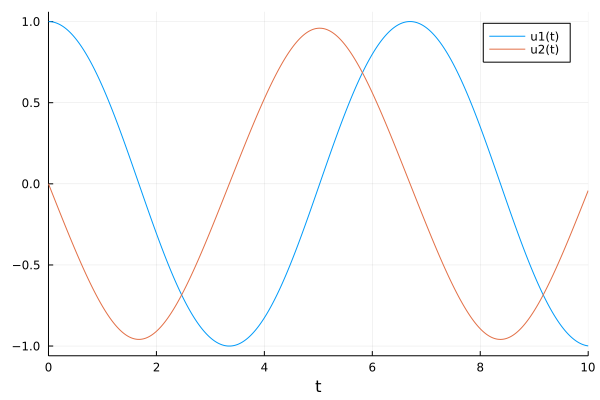

In [1]:
using DifferentialEquations, LinearAlgebra, Plots

u = solve(ODEProblem((u,_,x) -> [u[2], -sin(u[1])], [1,0], (0,10)))
plot(u)

However, even in these automated packages one has a choice of different methods with
different behaviour, so it is important to understand what is happening.

# 1.  Time-evolution problems

In this section we consider the forward and backward Euler methods, which are based on forward and backward difference
approximations to the derivative. In the problem sheet we will investigate a rule that that takes the average of the two
(with significant benefits). We first discuss the simplest case of indefinite integration, where central differences is also
applicable, then introduce forward and backward
Euler for linear scalar, linear vector, and nonlinear differential equations.


## Indefinite integration

We begin with the simplest differential equation on an interval $[a,b]$:
$$
\begin{align*}
u(a) &= c \\
u'(x) &= f(x)
\end{align*}
$$
Using the forward-difference (which is the standard finite-difference) approximation we 
choose $u_k ≈ u(x_k)$ so that, for $k = 1, …, n-1$:
$$
f(x_k) = u'(x_k) ≈ {u_{k+1} - u_k \over h} = f(x_k)
$$
That is, where $u$ satisfies the differential equation exactly, 
$u_k$ satisfies the _difference equation_ exactly.
We do not include $k = n$ to avoid going outside our grid.

This condition can be recast as a linear system:
$$
\underbrace{{1 \over h} \begin{bmatrix}
-1 & 1\\
& \ddots & \ddots \\
&& -1 & 1
\end{bmatrix}}_{D_h} 𝐮^{\rm f} = \underbrace{\begin{bmatrix} f(x_1) \\ \vdots \\ f(x_{n-1})
\end{bmatrix}}_{𝐟^{\rm f}}
$$
where the super-script ${\rm f}$ denotes that we are using 
forward differences (and is leading towards the
forward Euler method).
Here $D_h ∈ ℝ^{n-1,n}$ so this system is not-invertible. Thus we need to
add an extra row, coming from the initial condition: $𝐞_1^⊤ 𝐮^{\rm f} = c$,
that is:
$$
\begin{bmatrix}
𝐞_1^⊤ \\
D_h
\end{bmatrix} 𝐮^{\rm f} = \underbrace{ \begin{bmatrix}
1 \\
-1/h & 1/h\\
& \ddots & \ddots \\
&& -1/h & 1/h
\end{bmatrix}}_{L_h} 𝐮^{\rm f} = \begin{bmatrix} c \\ 𝐟^{\rm f} \end{bmatrix}
$$
This is a lower-triangular bidiagonal system, so can be solved using
forward substitution in $O(n)$ operations. 

We can also consider discretisation at the mid-point $m_k = {x_{k+1} - x_k \over 2}$,
which is the analogue of using central-differences:
$$
u'(m_k) ≈ {u_{k+1} - u_k \over h} = f(m_k)
$$
That is, we have the exact same system with a different right-hand side:
$$
\underbrace{{1 \over h} \begin{bmatrix}
-1 & 1\\
& \ddots & \ddots \\
&& -1 & 1
\end{bmatrix}}_{D_h} 𝐮^{\rm m} = 
\underbrace{\begin{bmatrix} f(m_1) \\ \vdots \\ f(m_{n-1})
\end{bmatrix}}_{𝐟^{\rm m}}
$$

And of course there is $𝐮^{\rm B}$ coming from the backwards-difference
formula:
$$
u'(x_k) ≈ {u_k - u_{k-1} \over h} = f(x_k)
$$
which we leave as an exercise.


**Example**

Let's do an example of integrating $\cos x$, and see if our method matches
the true answer of $\sin x$. First we construct the system
as a lower-triangular, `Bidiagonal` matrix:

In [2]:
using LinearAlgebra, Plots

function indefint(x)
    h = step(x) # x[k+1]-x[k]
    n = length(x)
    L = Bidiagonal([1; fill(1/h, n-1)], fill(-1/h, n-1), :L)
end

n = 10
x = range(0, 1; length=n)
L = indefint(x)

10×10 Bidiagonal{Float64, Vector{Float64}}:
  1.0    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    ⋅ 
 -9.0   9.0    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    ⋅ 
   ⋅   -9.0   9.0    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    ⋅ 
   ⋅     ⋅   -9.0   9.0    ⋅     ⋅     ⋅     ⋅     ⋅    ⋅ 
   ⋅     ⋅     ⋅   -9.0   9.0    ⋅     ⋅     ⋅     ⋅    ⋅ 
   ⋅     ⋅     ⋅     ⋅   -9.0   9.0    ⋅     ⋅     ⋅    ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅   -9.0   9.0    ⋅     ⋅    ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -9.0   9.0    ⋅    ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -9.0   9.0   ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -9.0  9.0

We can now solve for our particular problem using both the left and 
mid-point rules:

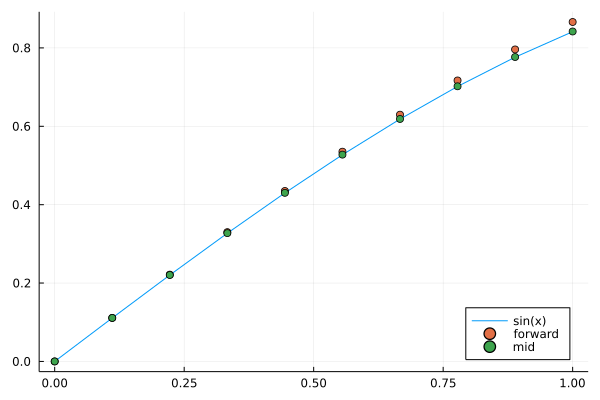

In [3]:
c = 0 # u(0) = 0
f = x -> cos(x)


m = (x[1:end-1] + x[2:end])/2 # midpoints


𝐟ᶠ = f.(x[1:end-1]) # evaluate f at all but last points
𝐟ᵐ = f.(m)          # evaluate f at mid-points
𝐮ᶠ = L \ [c; 𝐟ᶠ] # integrate using forward-differences
𝐮ᵐ = L \ [c; 𝐟ᵐ] # integrate using central-differences

plot(x, sin.(x); label="sin(x)", legend=:bottomright)
scatter!(x, 𝐮ᶠ; label="forward")
scatter!(x, 𝐮ᵐ; label="mid")

They both are close though the mid-point version is significantly
more accurate.
 We can estimate how fast it converges:

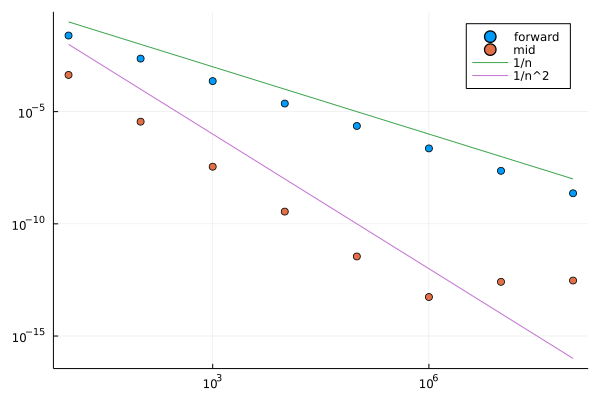

In [4]:
# Error from indefinite integration with c and f
function forward_err(u, c, f, n)
    x = range(0, 1; length = n)
    uᶠ = indefint(x) \ [c; f.(x[1:end-1])]
    norm(uᶠ - u.(x), Inf)
end

function mid_err(u, c, f, n)
    x = range(0, 1; length = n)
    m = (x[1:end-1] + x[2:end]) / 2 # midpoints
    uᵐ = indefint(x) \ [c; f.(m)]
    norm(uᵐ - u.(x), Inf)
end

ns = 10 .^ (1:8) # solve up to n = 10 million
scatter(ns, forward_err.(sin, 0, f, ns); xscale=:log10, yscale=:log10, label="forward")
scatter!(ns, mid_err.(sin, 0, f, ns); label="mid")
plot!(ns, ns .^ (-1); label="1/n")
plot!(ns, ns .^ (-2); label="1/n^2")

This is a log-log plot:we scale both $x$ and $y$ axes logarithmically so that
$n^α$ becomes a straight line where the slope is dictated by $α$.
We seem experimentally that the error for forward-difference is $O(n^{-1})$
while for mid-point/central-differences we get faster $O(n^{-2})$ convergence. 
Both methods appear to be stable.
 

## Forward Euler

Now consider a scalar linear time-evolution problem for $0 ≤ t ≤ T$:
$$
\begin{align*}
u(0 ) &= c \\
u'(t) - a(t) u(t) &= f(t)
\end{align*}
$$
Label the $n$-point grid as $t_k = (k-1)h$ for $h = T/(n-1)$.

**Definition (Restriction matrices)**
Define the $n-1 × n$ _restriction matrices_ as
$$
\begin{align*}
    I_n^{\rm f} := \begin{bmatrix} 1 \\ &⋱ \\ &&1 & 0 \end{bmatrix}\\
I_n^{\rm b} := \begin{bmatrix} 0 & 1 \\ &&⋱ \\ &&&1  \end{bmatrix} \\
\end{align*}
$$


Again we can replace the discretisation using finite-differences, giving us
$$
{u_{k+1} - u_k \over h} - a(t_k) u_k = f(u_k)
$$
for $k = 1,…,n-1$. We need to add the term $a(t_k) u_k$ to our differential equation,
that is. We do this using the $n-1 × n$ _(left) restriction matrix_ that takes a vector
evaluated at $x_1,…,x_n$ and restricts it to $x_1,…,x_{n-1}$,
as well as the $n × n$ _multiplication matrix_
$$
A_n = \begin{bmatrix} a(t_1) \\ &⋱\\&& a(t_n) \end{bmatrix}
$$
Putting everything together we have the system:
$$
\begin{bmatrix}
𝐞_1^⊤ \\
D_h -  I_n^{\rm f}  A_n
\end{bmatrix} 𝐮^{\rm f} = \underbrace{ \begin{bmatrix}
1 \\
-a(t_1)-1/h & 1/h\\
& \ddots & \ddots \\
&& -a(t_{n-1})-1/h & 1/h
\end{bmatrix}}_L 𝐮^{\rm f} = \begin{bmatrix} c \\ I_n^{\rm f} 𝐟 \end{bmatrix}
$$
where $𝐟 = \begin{bmatrix} f(t_1) \\ ⋮ \\ f(t_n) \end{bmatrix}$.

Here is a simple example for solving:
$$
u'(0) = 1, u' + t u = {\rm e}^t
$$
which has an exact solution in terms of a special error function
(which we determined using Mathematica).

In [5]:
using SpecialFunctions
c = 1
a = t -> t
n = 2000
t = range(0, 1; length=n)
# exact solution, found in Mathematica
u = t -> -(1/2)*exp(-(1+t^2)/2)*(-2sqrt(ℯ) + sqrt(2π)erfi(1/sqrt(2)) - sqrt(2π)erfi((1 + t)/sqrt(2)))

h = step(t)
L = Bidiagonal([1; fill(1/h, n-1)], a.(t[1:end-1]) .- 1/h, :L)

norm(L \ [c; exp.(t[1:end-1])] - u.(t),Inf)

3.555265078847292e-5

We see that it is converging to the true result.


Note that this is a simple forward-substitution of a bidiagonal system,
so we can also just construct it directly:
$$
\begin{align*}
u_1 &= c \\
u_{k+1} &= (1 + h a(t_k)) u_k + h f(t_k)
\end{align*}
$$


**Remark (advanced)** Note this can alternatively be reduced to an integral
$$
u(t) = c \hbox{e}^{a t} + \hbox{e}^{a t} \int_0^t f(τ) \hbox{e}^{-a τ} \hbox d τ
$$
and solved as above but this approach is harder to generalise.


## Backward Euler


In Backward Euler we replace the forward-difference with a backward-difference,
that is
$$
{u_k - u_{k-1} \over h} - a(t_k) u_k = f(u_k)
$$
This leads to the system:
$$
\begin{bmatrix}
𝐞_1^⊤ \\
D_h -  I_n^{\rm b}  A_n
\end{bmatrix} 𝐮^{\rm b} = \underbrace{ \begin{bmatrix}
1 \\
-a(t_1)-1/h & 1/h\\
& \ddots & \ddots \\
&& -a(t_{n-1})-1/h & 1/h
\end{bmatrix}}_L 𝐮^{\rm b} = \begin{bmatrix} c \\ I_n^{\rm b} 𝐟 \end{bmatrix}
$$
Again this is a bidiagonal forward-substitution:
$$
\begin{align*}
u_1 &= c \\
(1 - h a(t_{k+1})) u_{k+1} &= u_k + h f(t_{k+1})
\end{align*}
$$
That is,
$$
u_{k+1} = (1 - h a(t_{k+1}))^{-1}(u_k + h f(t_{k+1}))
$$



## Systems of equations

We can also solve systems, that is, equations of the form:
$$
\begin{align*}
𝐮(0) &= 𝐜 \\
𝐮'(t) - A(t) 𝐮(t) &= 𝐟(t)
\end{align*}
$$
where $𝐮, 𝐟 : [0,T] → ℝ^d$ and $A : [0,T] → ℝ^{d × d}$.
We again discretise at the grid $t_k$
by approximating $𝐮(t_k) ≈ 𝐮_k ∈ ℝ^d$.
This can be reduced to a block-bidiagonal system as in
the scalar case which is solved via forward-substitution. Though
it's easier to think of it directly. 

Forward Euler gives us:
$$
\begin{align*}
𝐮_1 &= c \\
𝐮_{k+1} &= 𝐮_k + h A(t_k) 𝐮_k + h 𝐟(t_k)
\end{align*}
$$
That is, each _time-step_ consists of matrix-vector multiplication.
On the other hand Backward Euler requires inverting a matrix
at each time-step:
$$
\begin{align*}
𝐮_1 &= c \\
𝐮_{k+1} &= (I- h A(t_{k+1})^{-1} (𝐮_k  + h 𝐟(t_{k+1}))
\end{align*}
$$


**Example (Airy equation)**
Consider the (negative-time) Airy equation:
$$
\begin{align*}
u(0) &= 1 \\
u'(0) &= 0 \\
u''(t) + t u &= 0
\end{align*}
$$
We can recast it as a system by defining
$$
𝐮(x) = \begin{bmatrix} u(x) \\ u'(x) \end{bmatrix}
$$
which satisfies
$$
\begin{align*}
𝐮(0) = \begin{bmatrix} 1 \\ 0 \end{bmatrix} \\
𝐮 - \begin{bmatrix} 0 & 1 \\ -t & 0 \end{bmatrix} 𝐮 = 𝟎.
\end{align*}
$$
It is natural to represent the _time-slices_ $𝐮_k$ as
columns of a matrix $U = [𝐮_1 | ⋯ | 𝐮_n] ∈ ℝ^{2 × n}$. Thus we get:

In [6]:
n = 100_000
t = range(0, 50; length=n)
A = t -> [0 1; -t 0]
h = step(t)

U = zeros(2, n) # each column is a time-slice
U[:,1] = [1.0,0.0] # initial condition
for k = 1:n-1
    U[:,k+1] = (I + h*A(t[k]))*U[:,k]
end

plot(t, U')

We leave implementation of backward Euler as a simple exercise.

**Example (Heat on a graph)**
Those who took Introduction to Applied Mathematics will recall
heat equation on a graph. Consider a simple graph of $m$ nodes labelled
$1, …, m$ where node $k$ is connected to neighbouring nodes ${k-1}$ and ${k+1}$,
whereas node $1$ is only connected to node $2$ and node $m$ only connected to
${m-1}$. The graph Laplacian corresponding to this system is the matrix:
$$
Δ := \begin{bmatrix} -1 & 1 \\ 
            1 & -2 & ⋱ \\ 
            & 1 & ⋱ & 1 \\
            && ⋱ & -2 & 1 \\
                &&& 1 & -1
                \end{bmatrix}
$$
If we denote the heat at time $t$ at node $k$ as $u_k(t)$,
which we turn into a vector
$$
𝐮(t) = \begin{bmatrix} u_1(t) \\ ⋮ \\ u_m(t) \end{bmatrix}
$$
We consider the case of a periodic forcing at the node $n = 1$.

Heat equation on this lattice is defined as follows:
$$
𝐮' = Δ𝐮 + 𝐞_1 \cos ωt
$$
We can employ forward and backward Euler:

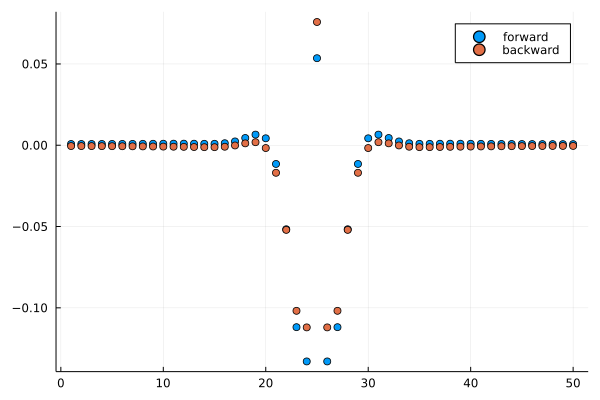

In [7]:
n = 1_000 # number of time-steps
t = range(0, 100; length=n)
h = step(t)

m = 50 # number of nodes


Δ = SymTridiagonal([-1; fill(-2.0, m-2); -1], ones(m-1))
ω = 1
f = t -> cos(ω*t) # periodic forcing with period 1

Uᶠ = zeros(m, n) # each column is a time-slice for forward Euler
Uᵇ = zeros(m, n) # each column is a time-slice for backwar Euler

Uᶠ[:,1] = Uᵇ[:,1] = zeros(m) # initial condition



for k = 1:n-1
    Uᶠ[:,k+1] = (I + h*Δ)*Uᶠ[:,k]
    Uᶠ[m÷2,k+1] += h*f(t[k]) # add forcing at 𝐞_1
end

𝐞 = zeros(m); 𝐞[m÷2] = 1;

for k = 1:n-1
    Uᵇ[:,k+1] = (I - h*Δ)\(Uᵇ[:,k] + h*f(t[k+1])𝐞)
end

scatter(Uᶠ[:,end]; label="forward")
scatter!(Uᵇ[:,end]; label="backward")

Both match! 

**Remark** If you change the number of time-steps to be too small, for example `n = 100`, forward
Euler blows up while backward Euler does not. This will be discussed in the problem
sheet.

**Remark (advanced)** Memory allocations are very expensive so
in practice one should preallocate and use memory. 


## Nonlinear problems

Forward-Euler extends naturally to nonlinear equations, 
including the
vector case:
$$
𝐮' = f(t, 𝐮(t))
$$
becomes:
$$
𝐮_{k+1} = 𝐮_k + h f(x_k, 𝐮_k)
$$
Here we show a simple solution to a nonlinear Pendulum:
$$
u'' = \sin u
$$
by writing $𝐮 = [u,u']$ we have:
$$

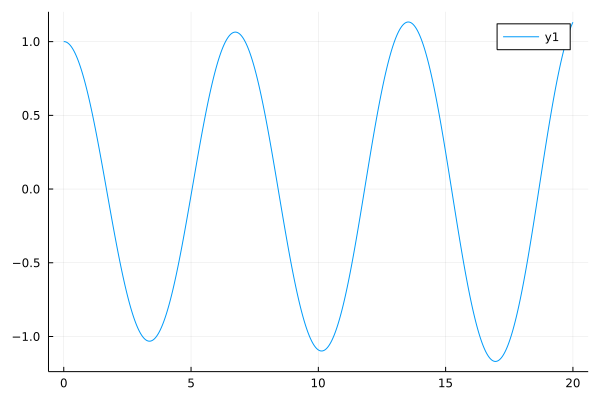

In [8]:
n = 1000
𝐮 = fill(zeros(2), n)
x = range(0, 20; length=n)
h = step(x) # same as x[k+1]-x[k]

𝐮[1] = [1,0]
for k = 1:n-1
    𝐮[k+1] = 𝐮[k] + h * [𝐮[k][2],-sin(𝐮[k][1])]
end

plot(x, first.(𝐮))

As we see it correctly predicts the oscillatory behaviour of
a pendulum, and matches the simulation using DifferentialEquations.jl
above.



# 2. Two-point boundary value problems

Here we will only consider one discretisation as it is symmetric:
$$
u''(x_k) ≈ {u_{k-1} - 2u_k + u_{k+1} \over h^2}
$$
That is we use the $n-1 × n+1$ matrix:
$$
D_h^2 := {1 \over h^2} \begin{bmatrix}
1 & -2 & 1 \\ & ⋱ & ⋱ & ⋱ \\
&& 1 & -2 & 1 
\end{bmatrix}
$$


**Example (Poisson)** Consider the Poisson equation with Dirichlet conditions:
$$
\begin{align*}
u(0) &= c_0 \\
u'' &= f(x) \\
u(1) &= c_1
\end{align*}
$$
which we discretise as
$$
\begin{align*}
u_0 &= c_0 \\
 {u_{k-1} - 2u_k + u_{k+1} \over h^2} &= f(x_k) \\
u_1 &= c_1
\end{align*}
$$
As a linear system this equation becomes:
$$
\begin{bmatrix}
𝐞_1^⊤ \\
D_h^2 \\
𝐞_{n+1}^⊤
\end{bmatrix} 𝐮 = \begin{bmatrix} c_0 \\ f(x_2) \\ ⋮ \\ f(x_{n-1}) \\ c_1 \end{bmatrix}
$$

Thus we solve:

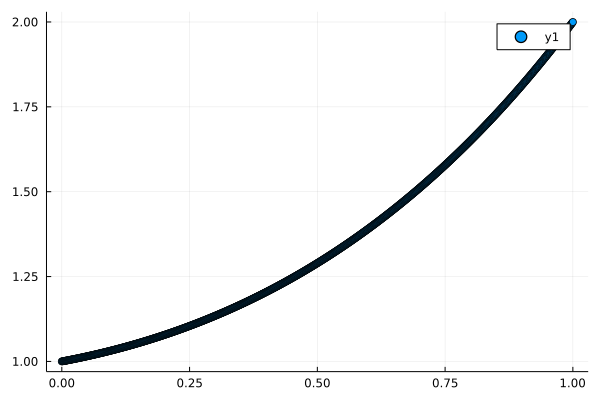

In [9]:
x = range(0, 1; length = n)
h = step(x)
T = Tridiagonal([fill(1/h^2, n-2); 0], [1; fill(-2/h^2, n-2); 1], [0; fill(1/h^2, n-2)])
u = T \ [1; exp.(x[2:end-1]); 2]
scatter(x, u)

We can test convergence on $u(x) = \cos x^2$ which satisfies
$$
\begin{align*}
u(0) = 1 \\
u(1) = \cos 1 \\
u''(x) = -4x^2*cos(x^2) - 2sin(x^2)
\end{align*}
$$
We observe uniform ($∞$-norm) convergence:

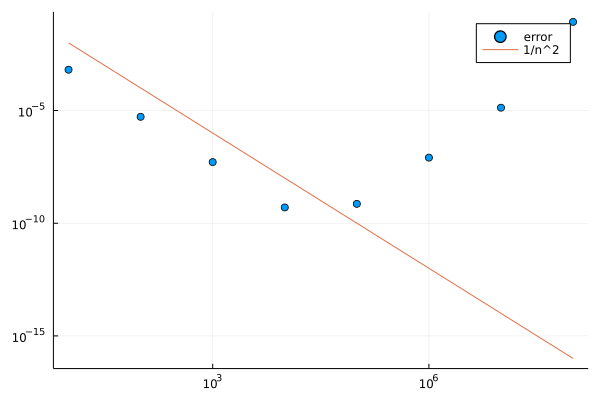

In [10]:
function poisson_err(u, c_0, c_1, f, n)
    x = range(0, 1; length = n)
    h = step(x)
    T = Tridiagonal([fill(1/h^2, n-2); 0], [1; fill(-2/h^2, n-2); 1], [0; fill(1/h^2, n-2)])
    uᶠ = T \ [c_0; f.(x[2:end-1]); c_1]
    norm(uᶠ - u.(x), Inf)
end

u = x -> cos(x^2)
f = x -> -4x^2*cos(x^2) - 2sin(x^2)

ns = 10 .^ (1:8) # solve up to n = 10 million
scatter(ns, poisson_err.(u, 1, cos(1), f, ns); xscale=:log10, yscale=:log10, label="error")
plot!(ns, ns .^ (-2); label="1/n^2")

## 3. Convergence

We now study convergence of the approaches for the constant-coefficient case.
We will use _Toeplitz matrices_ as a tool to simplify the explanation.

**Definition (Toeplitz)** A _Toeplitz matrix_ has constant diagonals: $T[k,j] = a_{k-j}$.


**Proposition (Bidiagonal Toeplitz inverse)**
The inverse of a $n × n$ bidiagonal Toeplitz matrix is:
$$
\begin{bmatrix}
1 \\
-ℓ & 1 \\
&-ℓ & 1 \\
&& ⋱ & ⋱ \\
&&& -ℓ & 1\end{bmatrix} = 
 \begin{bmatrix} 1 \\
                            ℓ & 1 \\
                            ℓ^2 & ℓ & 1 \\
                            ⋮ & ⋱ & ⋱ & ⋱ \\
                            ℓ^{n-1} & ⋯ & ℓ^2 & ℓ & 1
\end{bmatrix}              
$$

**Theorem (Forward/Backward Euler convergence)**
Consider the equation
$$
u(0) = c, u'(t) + a u(t) = f(t)
$$
Denote
$$
𝐮 := \begin{bmatrix} u(t_1) \\ ⋮ \\ u(t_n) \end{bmatrix}
$$
Assume that $u$ is twice-differentiable with uniformly bounded
second derivative.
Then the error for forward/backward Euler is
$$
\|𝐮ᶠ - 𝐮\|_∞, \|𝐮ᵇ - 𝐮\|_∞ = O(n^{-1})
$$

**Proof** 
We prove the error bound for forward Euler as backward Euler is
similar. This proof consists of two stages: (1) consistency and
(2) stability. 

_Consistency_ means our discretisation approximates the
true equation, that is:
$$
L𝐮 = \begin{bmatrix} c \\
        {u(t_2) - u(t_1) \over h} + a u(t_1) \\
        ⋮ \\
        {u(t_n) - u(t_{n-1}) \over h} + a u(t_{n-1}) 
\end{bmatrix} = \begin{bmatrix} c \\
        u'(t_1) + a u(t_1) + u''(τ_1) h \\
        ⋮ \\
        u'(t_{n-1}) + a u(t_{n-1}) + u''(τ_{n-1}) h
\end{bmatrix} = \begin{bmatrix} c \\
        f(t_1) + u''(τ_1) h \\
        ⋮ \\
        f(t_{n-1}) + u''(τ_{n-1}) h
\end{bmatrix} = \begin{bmatrix} c \\ 𝐟ᶠ \end{bmatrix} + \begin{bmatrix} 0 \\ δ \end{bmatrix}
$$
where $t_k ≤ τ_k ≤ t_{k+1}$, and uniform boundedness
implies that $\|δ\|_∞ = O(h)$, or in other words $\|δ\|_1 = O(1)$. 

_Stability_ means the inverse does not
blow up the error. We need to be a bit careful and
first write, for $ℓ = 1 + h a$,
$$
L = \underbrace{\begin{bmatrix} 1 \\ & h^{-1} \\ && ⋱ \\ &&& h^{-1} \end{bmatrix}}_D
 \underbrace{\begin{bmatrix} 1 \\ 
                        -ℓ & 1 \\ & ⋱ & ⋱ \\
                        && -ℓ &1 \end{bmatrix}}_{L̃}
$$
Stability in this case is the statement that
$$
\|L̃^{-1}\|_{1 → ∞} ≤ (1 +  |a|/n)^{n-1} = O(1)
$$
using the fact (which likely you have seen in first year) that
$$
\lim_{n → ∞}  (1 +  |a|/n)^{n-1} = \exp|a|.
$$


We now combine stability and consistency. have
$$
\|𝐮ᶠ - 𝐮\|_∞  = \|L^{-1} (L𝐮ᶠ - L𝐮)\|_∞  = \|L̃^{-1} D^{-1} \begin{bmatrix} 0 \\ δ \end{bmatrix} \|_∞ 
≤ h \|L̃^{-1}\|_{1 → ∞} \|δ\|_1 = O(h).
$$

∎


### Poisson

For 2D problems we consider Poisson. The first stage is to
row-reduce to get a symmetric tridiagonal (pos. def.) matrix:
$$
\begin{bmatrix} 
1 \\
-1/h^2 & 1 \\
    && 1 \\ 
    &&& ⋱ \\
    &&&& 1 & -1/h^2 \\
    &&&&& 1\end{bmatrix} \begin{bmatrix}
    1 \\
    1/h^2 & -2/h^2 & 1/h^2 \\
        & ⋱ & ⋱ & ⋱ \\
        && 1/h^2 & -2/h^2 & 1/h^2 \\
        &&&& 1 \end{bmatrix} = 
\begin{bmatrix}
    1 \\
    0 & -2/h^2 & 1/h^2 \\
        & ⋱ & ⋱ & ⋱ \\
        && 1/h^2 & -2/h^2 & 0 \\
        &&&& 1 \end{bmatrix}.
$$
Considering the right-hand side and dropping
the first and last rows our equation becomes:
$$
{1 \over h^2} \underbrace{\begin{bmatrix}
 -2 & 1 \\
        1 & -2 & ⋱ \\
        & ⋱ &  ⋱ & 1 \\
        && 1 & -2  
        \end{bmatrix}}_Δ \begin{bmatrix}
                u_2 \\ ⋮ \\ u_{n-1} \end{bmatrix} = \underbrace{\begin{bmatrix} f(x_2) - c_0/h^2 \\ f(x_3) \\ ⋮ \\ f(x_{n-2}) \\ f(x_{n-1}) - c_1/h^2 \end{bmatrix}}_{𝐟ᵖ}
$$


**Remark (advanced)** You may recognise $Δ$ as a discrete Laplacian corresponding to a graph with
Dirichlet conditions,
as discussed in first year applied mathematics.
Thus one can interpret finite-differences as approximating a continuous differential equation by
a graph. This view-point extends naturally to higher-dimensional equations. In the problem sheet we also
discuss Neumann series.


**Theorem (Poisson convergence)** Suppose that $u$ is four-times differentiable with uniformly
bounded fourth derivative. Then the finite difference approximation to Poisson converges like $O(n^2)$.


**Proof**


For consistency we need the Taylor series error of second-order finite differences. We have
$$
\begin{align*}
u(x+h) = u(x) + h u'(x) + h^2 {u''(x) \over 2} + h^3 {u'''(x) \over 6} +  h^4 {u^{(4)}(t_+) \over 24}  \\
u(x-h) = u(x) - h u'(x) + h^2 {u''(x) \over 2} - h^3 {u'''(x) \over 6}  +  h^4 {u^{(4)}(t_-)  \over 24}
\end{align*}
$$
where $t_+ ∈ [x,x+h]$ and $t_- ∈ [x-h,x]$. 
Thus
$$
{u(x+h) - 2u(x) + u(x-h) \over h^2} = u''(x) + h^2 {u^{(4)}(t_+) + u^{(4)}(t_-) \over 24} = u''(x) + O(h^2)
$$
(Note this is a slightly stronger result than used in the solution of PS2.)
Thus we have _consistency_:
$$
{Δ \over h^2} \begin{bmatrix} u_2 \\ ⋮ \\ u_{n-1} \end{bmatrix} = 𝐟ᵖ + {\bf\delta}
$$
where $\|{\bf\delta}\|_∞ = O(h^2)$.


Following PS5 we deduce that it has the Cholesky-like decomposition
$$
Δ = -\underbrace{\begin{bmatrix} 1 & -1 \\  & ⋱ & ⋱ \\ && 1 & -1 \\ &&& 1 \end{bmatrix}}_U \underbrace{\begin{bmatrix} 1 \\ -1 & 1 \\ & ⋱ & ⋱ \\ && -1 & 1 \end{bmatrix} }_{U^⊤}
$$
We can invert:
$$
U^{-1} = \begin{bmatrix} 1 & 1 & ⋯ & 1 \\ & ⋱ & ⋱ & ⋮ \\
                                        && 1 & 1 \\ &&& 1 \end{bmatrix}
$$
Thus we have _stability_: $\|h^2 Δ^{-1}\|_∞ ≤ h^2 \|U^{-1}\|_{∞} \|U^{-⊤}\|_{∞} = 1$.

Putting everything together we have, for $𝐮 = [u(x_1), …, u(x_n)]^⊤$,
$$
\|𝐮ᶠ - 𝐮\|_∞  = \|Δ^{-1} (Δ𝐮ᶠ - Δ𝐮)\|_∞  ≤ \|h^2  Δ^{-1}\|_∞  \| {\bf\delta} \|_∞ = O(n^{-2})
$$

∎

What about the observed instability? The condition number of the matrix provides an intuition
(though not a proof: condition numbers are only upper bounds!).  Here we have
$$
κ_∞(Δ/h^2) = κ_∞(Δ) = \|Δ\|_∞ \|Δ^{-1}\|_∞ ≤ 2 n^2
$$
One can show by looking at $Δ^{-1}$ directly that the condition number is indeed growing like $n^2$.
Thus we _expect_ floating-point errors to magnified propotional to $n^2$ in the linear solve.